# Engenharia do Conhecimento 2022/2023

## TP08: Feature Selection, Dimensionality Reduction and Model Tuning
*A Machine Learning Tutorial by Andre Falcao (DI/FCUL 2020-2022)
*revised by Catia Pesquita (DI/FCUL 2022-2023)*

### Summary

1. Feature selection
    1. Using corelation
    2. Using stepwise methods
    3. Random Forests for Feature Selection
2. Principal Components analysis
    1. Linear PCA
    2. Kernel PCA
3. Model Tuning


## 1. Feature selection

### 1.1 Correlation

We are going to start by getting our favourite libraries and our dataset arranged for Binary Classification

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, confusion_matrix,matthews_corrcoef, precision_score, recall_score
from sklearn.metrics import explained_variance_score, mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor



Now get the diabetes dataset

In [2]:

from sklearn.datasets import load_diabetes

X_diabetes, y_diabetes=load_diabetes(return_X_y=True)

#we will not use these
yc_diabetes=np.array([int(i>=250) for i in y_diabetes])
vals, counts= np.unique(yc_diabetes, return_counts=True)
for v, c in zip(vals, counts):
    print("# of ",v, "--->", c)


# of  0 ---> 377
# of  1 ---> 65


Let's make a simplistic evaluation function running 3 algorithms and producing the RVE for each

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_diabetes, y_diabetes, test_size=0.33, random_state=0)

def naive_model_testing(X_train, X_test, y_train, y_test):
    #test 3 approaches and print out the results
    
    rfr= RandomForestRegressor(n_estimators=100)
    rfr.fit(X_train, y_train)

    dtr= DecisionTreeRegressor(max_depth=5)
    dtr.fit(X_train, y_train)

    lmr=LinearRegression()
    lmr.fit(X_train, y_train)

    rf_preds=rfr.predict(X_test)
    dt_preds=dtr.predict(X_test)
    lr_preds=lmr.predict(X_test)

    print("RVE RFs: %7.4f" % explained_variance_score(y_test, rf_preds))
    print("RVE DTs: %7.4f" % explained_variance_score(y_test, dt_preds))
    print("RVE LRs: %7.4f" % explained_variance_score(y_test, lr_preds))

naive_model_testing(X_train, X_test, y_train, y_test)

RVE DTs:  0.1398
RVE LRs:  0.4034


### Correlation 

As a first exercise we are going to use the Pearson correlation. First, we will modify the X matrix to include the y, so that we can use the `corrcoef` method of numpy

the y column will appear as the first column

In [4]:
#first append the y to the X matrix
N,M=X_train.shape
N,M
v=np.hstack((y_train.reshape((N,1)), X_train))
temp = pd.DataFrame(v)

,0,1,2,3,4,5,6,7,8,9,10
0,96.0,-0.049105,-0.044642,-0.064408,-0.102071,-0.002945,-0.015406,0.063367,-0.047243,-0.033249,-0.054925
1,125.0,-0.027310,-0.044642,-0.035307,-0.029771,-0.056607,-0.058620,0.030232,-0.039493,-0.049868,-0.129483
2,182.0,0.012648,-0.044642,0.006728,-0.056166,-0.075870,-0.066449,-0.021311,-0.037648,-0.018118,-0.092204
3,177.0,0.030811,0.050680,-0.008362,0.004658,0.014942,0.027496,0.008142,-0.008127,-0.029528,0.056912
4,48.0,-0.020045,-0.044642,0.004572,0.097616,0.005311,-0.020729,0.063367,-0.039493,0.012553,0.011349
...,...,...,...,...,...,...,...,...,...,...,...
291,248.0,0.070769,0.050680,-0.007284,0.049415,0.060349,-0.004445,-0.054446,0.108111,0.129019,0.056912
292,91.0,0.056239,0.050680,-0.030996,0.008101,0.019070,0.021233,0.033914,-0.039493,-0.029528,-0.059067
293,281.0,0.059871,-0.044642,-0.021295,0.087287,0.045213,0.031567,-0.047082,0.071210,0.079121,0.135612
294,142.0,-0.078165,-0.044642,-0.073030,-0.057314,-0.084126,-0.074277,-0.024993,-0.039493,-0.018118,-0.083920


now we can compute and view the correlation matrix (note that we are interested only on the first column (0) which shows the correlation between each variable and the label y.

In [5]:
pd.DataFrame(np.corrcoef(v.T))


,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,0.186352,0.043168,0.620000,0.468876,0.233901,0.186562,-0.417253,0.436705,0.601545,0.393538
1,0.186352,1.000000,0.132526,0.181342,0.371535,0.297355,0.246133,-0.087652,0.233726,0.298130,0.326439
2,0.043168,0.132526,1.000000,0.084142,0.226160,0.049070,0.160898,-0.361308,0.325826,0.118335,0.233735
3,0.620000,0.181342,0.084142,1.000000,0.440965,0.287913,0.297240,-0.369131,0.409060,0.461002,0.407335
4,0.468876,0.371535,0.226160,0.440965,1.000000,0.289781,0.235435,-0.246348,0.325821,0.446331,0.436451
5,0.233901,0.297355,0.049070,0.287913,0.289781,1.000000,0.891518,0.010557,0.545208,0.539299,0.353586
6,0.186562,0.246133,0.160898,0.297240,0.235435,0.891518,1.000000,-0.241522,0.663837,0.332095,0.319455
7,-0.417253,-0.087652,-0.361308,-0.369131,-0.246348,0.010557,-0.241522,1.000000,-0.760616,-0.396705,-0.312373
8,0.436705,0.233726,0.325826,0.409060,0.325821,0.545208,0.663837,-0.760616,1.000000,0.609241,0.454094
9,0.601545,0.298130,0.118335,0.461002,0.446331,0.539299,0.332095,-0.396705,0.609241,1.000000,0.488109


### Exercise 1.1

1. Identify the Top 5 most correlated variables to the y
2. Check if this variable selection is capable of better results than using all variables

In [20]:
#Exercise 1.1

### 1.2. Stepwise Feature selection

Here we are going to use the [Sequential Selector form scikit](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector) which takes any supervised method and runs the forward or the backward methods for defining the most relevant variables

By default it uses the forward method and we are going to select the best 5 features

In [7]:
from sklearn.feature_selection import SequentialFeatureSelector

N,M=X_train.shape

#using linear regression for sequential feature selection
lmr=LinearRegression()
sfs = SequentialFeatureSelector(lmr, n_features_to_select=5)
sfs.fit(X_train, y_train)

#get the relevant columns
features=sfs.get_support()
Features_selected = np.arange(X.shape[1])[features]
print("The features selected are columns: ", Features_selected)

nX_train=sfs.transform(X_train)
nX_test=sfs.transform(X_test)

naive_model_testing(nX_train, nX_test, y_train, y_test)

The features selected are columns:  [2 3 4 5 8]
RVE DTs:  0.0408
RVE LRs:  0.3707


### Exercise 1.2

1. Run forward sequential fitting for a decision tree with max_depth=3

2. Change the direction to "backward"

In [19]:
#Exercise 1.2


## 2. Principal Components Analysis

We are going to use the [PCA module](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from scikit-learn

First let's just find a 2D projection of our data (remember to use only the training set)

In [9]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)#finding the two best PCs
pca.fit(X_train)
tve=0 #total variance explained
for i, ve in enumerate(pca.explained_variance_ratio_):
    tve+=ve
    print("PC%d - Variance explained: %7.4f - Total Variance: %7.4f" % (i, ve, tve) )
print()
print("Actual Eigenvalues:", pca.singular_values_)
for i,comp in enumerate(pca.components_):
    print("PC",i, "-->", comp)
    

PC0 - Variance explained:  0.4224 - Total Variance:  0.4224
PC1 - Variance explained:  0.1390 - Total Variance:  0.5614

Actual Eigenvalues: [1.70882699 0.9802319 ]
PC 0 --> [ 0.22452345  0.17011346  0.30125635  0.28754891  0.33044233  0.3381175
 -0.28709548  0.41864321  0.37460412  0.35451529]
PC 1 --> [ 0.15942693 -0.40467058 -0.10862844 -0.07331791  0.55461902  0.40055727
  0.55072849 -0.12697241  0.01754937 -0.07660874]


### Exercise 2

1. Interpret the results above. 
   
1.1 What is the meaning of the PC vectors?

Now let's project the data using the principal components defined and use them for regression

In [10]:
nX_train=pca.transform(X_train)
nX_test=pca.transform(X_test)
naive_model_testing(nX_train, nX_test, y_train, y_test)

RVE DTs:  0.1715
RVE LRs:  0.2923


### A graphical view illustrated with binary classification data

Let's plot the projection in 2 components 

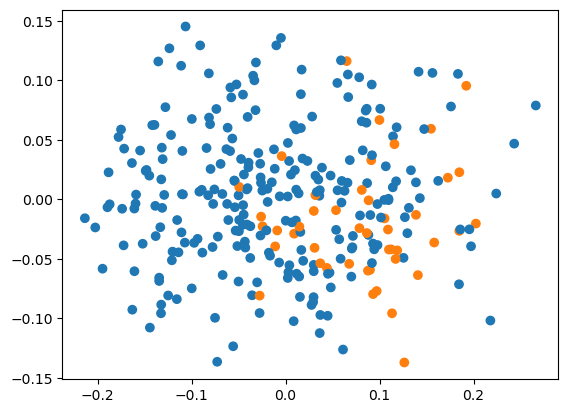

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_diabetes, yc_diabetes, test_size=0.33, random_state=0)
nX_train=pca.transform(X_train)
nX_test=pca.transform(X_test)
colors=np.array(["tab:blue", "tab:orange"])[y_train]
plt.scatter(nX_train[:,0], nX_train[:,1], c=colors)
plt.show()

## 3. Model Tuning

For this example we are going to use Support Vector Classifiers, but any model learned so far can be used

We are going to use [Scikit-Learn's GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), a very handy implementation of extensive parameter search. In its basic form it just requires:
* a bare bones model constructor 
* a dictionary containing the parameters to search for. The keys of the dictionary should correspond to the parameter to test and the values to a list of possible values to test
* a scoring function defining what is the criterion to select and rank the best models
* GridSearchCV uses by default 5-Fold Cross validation, but other validation criteria can be used

The result of GridSearchCV is a structure that contains the fitted models that can then be used for learning and application

Tet's try it with the C and gamma values for support vector classification


In [12]:

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#make the dictionary with the testing parameters
gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
Cs = [1, 10, 100, 1e3, 1e4, 1e5]
param_grid = {"gamma": gammas, "C": Cs}

#define the model and do the grid search
clf = SVC()
gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="f1")
gs=gs.fit(X_train, y_train)


Let's identify the best element parameters [best according to the scoring function, in this case it is the F1 score]

In [13]:
print("best gamma: %7.4f" % gs.best_estimator_.gamma)
print("best C: %3.2f" %  gs.best_estimator_.C)

best gamma:  0.1000
best C: 1000.00


Now we can use the best estimator model (the one with the optimized parameters) for prediction

In [14]:
preds=gs.best_estimator_.predict(X_test)
print("MCC: %7.4f" % matthews_corrcoef(y_test, preds))
print("Prc: %7.4f" % precision_score(y_test, preds))
print("Rec: %7.4f" % recall_score(y_test, preds))
print("F1 : %7.4f" % f1_score(y_test, preds))

MCC:  0.4610
Prc:  0.6667
Rec:  0.4000
F1 :  0.5000


GridSearchCV gives you a number of statistics on the tests it runs:

In [15]:

for i in gs.cv_results_.keys(): print(i)

mean_fit_time
std_fit_time
mean_score_time
std_score_time
param_C
param_gamma
params
split0_test_score
split1_test_score
split2_test_score
split3_test_score
split4_test_score
mean_test_score
std_test_score
rank_test_score


We can print the results in a nice Pandas Data Frame

In [16]:
res = pd.DataFrame(gs.cv_results_)
res = res.sort_values(by=["rank_test_score"]) #sort the tested models by score
res[["params", "rank_test_score", "mean_test_score", "std_test_score"]] #show only mean and std of the test score

,params,rank_test_score,mean_test_score,std_test_score
21,"{'C': 1000.0, 'gamma': 0.1}",1,0.490641,0.095452
37,"{'C': 100000.0, 'gamma': 0.001}",2,0.483974,0.093379
29,"{'C': 10000.0, 'gamma': 0.01}",3,0.458333,0.111803
28,"{'C': 10000.0, 'gamma': 0.1}",4,0.433032,0.110277
36,"{'C': 100000.0, 'gamma': 0.01}",5,0.432967,0.070312
35,"{'C': 100000.0, 'gamma': 0.1}",6,0.425770,0.133787
14,"{'C': 100, 'gamma': 0.1}",7,0.288485,0.182125
22,"{'C': 1000.0, 'gamma': 0.01}",7,0.288485,0.182125
30,"{'C': 10000.0, 'gamma': 0.001}",7,0.288485,0.182125
38,"{'C': 100000.0, 'gamma': 0.0001}",7,0.288485,0.182125


### Exercise 3
1. Discuss the values above in terms of coherency of the parameters found. Do you find a pattern in the best values for C and gamma?
2. Compare the first 5 models results using the testing set and discuss your findings


In [21]:
#Exercise 3
#for params in res['params'][:5]: #selecting the best five models
    #uncomment and complete the code